In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from kaggler.preprocessing import LabelEncoder

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

# 데이터 불러오기

In [2]:
train = pd.read_csv('./open/train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./open/test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./open/sample_submission.csv')

In [3]:
# day를 year로 변경해주는 함수
def days_to_age(x):
    return (x*-1)/365

In [4]:
# 마이너스 변환
def minus(x):
    return x * -1

# 이상치 제거
다른 변수들을 기준으로 이상치를 제거 하였을 때는 의미가 없었지만
child_num을 기준으로 값의 차이가 많이 나는 경우에만 제거 해주었습니다.
실제로 제거 되는 값을 보면 child_num이 14와 19로 데이터를 신뢰할 수 있는지 의문이 들었습니다.

In [5]:
def remove_outlier(train, column):
    
    df = train[column]
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 6
    highest = quan_75 + iqr * 6
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    print(df.iloc[outlier_index])
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train


In [6]:
candidate = ['child_num']
for cand in candidate:  
    train = remove_outlier(train,cand)

train.reset_index(drop = True,inplace = True)
len(train)

outlier의 수 :  4
8462     14
9021     14
10731    19
25390    14
Name: child_num, dtype: int64


26453

# 변수 조합으로 추가 변수 생성하기

In [7]:
def add_var(data):
    
    # 개개인을 구분할 수 있는 변수들을 묶어서 생성
    data['personal_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str)
    
    # 카드를 생성한 기간도 같은 경우가 있어서 begin을 추가하여 하나의 변수를 더 생성
    data['personal_begin_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str) + "_" + data['begin_month'].apply(str)
    
    # 그외의 변수들을 조합하여 하나의 변수로 추가 생성
    data['g_r_c'] = data['gender'] + "_" + data['reality'] + "_" + data['car'] 
    data['p_w_e'] = data['phone'].astype(str) + "_" + data['work_phone'].astype(str) + "_" + data['email'].astype(str) 
    #data['f_i'] = data['family_type'] + "_" + data['income_type']
    
    return data

In [8]:
train = add_var(train)
test = add_var(test)

# 숫자형 변수 전처리 및 변수 생성

다양한 방법으로 전처리 및 변수 생성을 진행하면서 성능이 제일 잘 나온 경우로 정리하였습니다.

In [9]:
def numeric_process(data):
    
    # income_total 변수 전처리
    # 만단위로 생성
    data['income_total'] = data['income_total']/10000
    # 편차 제곱 변수 생성
    data['income_total_dev'] = (data['income_total'] - data['income_total'].mean())**2
    # 로그 변환
    data['income_total_log'] = data['income_total'].apply(np.log1p)

    # DAYS_EMPLOYED 변수 전처리
    # 0 이상인 경우 0으로 모두 변환
    data.loc[data['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
    # day를 year로 변환
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_age)
    # 로그 변환
    data['DAYS_EMPLOYED_log'] = data['DAYS_EMPLOYED'].apply(np.log1p)

    # begin_month 변수 전처리
    # 마이너스 변환
    data['begin_month'] = data['begin_month'].apply(minus)
    
    # DAYS_BIRTH 변수 전처리
    # day를 year로 변환
    data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_age)

    #  DAYS_BIRTH, DAYS_EMPLOYED, income_total변수를 조합하여 RATIO 변수 생성
    data['EMPLOYED_BIRTH_RATIO'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH']
    data['INCOME_EMPLOYED_RATIO'] = data['income_total']/data['DAYS_EMPLOYED']
    data['INCOME_BIRTH_RATIO'] = data['income_total']/data['DAYS_BIRTH']
    
    # 가족수 - 자식수
    data['diff_fam_child'] = data['family_size'] - data['child_num']
    # chid_num과 family_size는 다음과 같이 최대 2와 5가 되도록 전처리
    data.loc[data['child_num'] >= 2,'child_num'] = 2
    data.loc[data['family_size'] >= 4,'child_num'] = 4
    
    # 가족수와 자녀수 sum
    data['FAM_CHILD_SUM'] = data[['child_num', 'family_size']].sum(axis=1)
    
    # income을 가족 수 및 자식 수로 나눈 비율
    data['INCOME_FAM_RATIO'] = data['income_total']/data['family_size']
    data['INCOME_child_num_RATIO'] = data['income_total']/data['child_num']
    
    # 일을하게 된 시점 변수 추가
    data['before_EMPLOYED'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
    data['INCOME_before_EMPLOYED_RATIO'] = data['income_total']/data['before_EMPLOYED']
    
    return data 

In [10]:
train = numeric_process(train)
test = numeric_process(test)

In [11]:
def occype_process(data):
    
    # 경력이 없고 직업군이 none인 사람은 no_work로 대체
    data['occyp_type'] = data['occyp_type'].fillna('NAN')
    data.loc[(data['DAYS_EMPLOYED'] == 0) & (data['occyp_type'] == 'NAN'), 'occyp_type'] = 'no_work'
    print(data['occyp_type'].value_counts())

    return data


In [12]:
train = occype_process(train)
test = occype_process(test)

Laborers                 4512
no_work                  4438
NAN                      3733
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1572
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      123
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64
Laborers                 1699
no_work                  1697
NAN                      1455
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
Medicine staff            343
High skill tech staff     343
Accountants               339
Cooking staff             198
Security staff            168
Cleaning 

# PCA 변수 추가

In [13]:
from sklearn.decomposition import PCA
def pca(data, columns):
    pca = PCA(n_components=1) # 주성분을 몇개로 할지 결정
    printcipalComponents = pca.fit_transform(data[columns])
    principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1'])
    data['pca_1'] = principalDf['principal component1']
    data['pca_2'] = principalDf['principal component1']
    
    return data

In [14]:
train = pca(train, ['income_total', 'DAYS_EMPLOYED', 'DAYS_BIRTH'])
test = pca(test, ['income_total', 'DAYS_EMPLOYED', 'DAYS_BIRTH'])

# 구간화 변수 생성

In [15]:
#구간화 함수
def make_bin(df, variable, n):
    
    data = df
    count, bin_dividers = np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data['%s_bin' % variable] = pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]
    print(data['%s_bin' % variable])
    
    return data

In [16]:
# days_birth만 구간화 했을 떄 가장 성능이 좋았음

train = make_bin(train, 'DAYS_BIRTH', n=10)
# train = make_bin(train, 'income_total_log', n=20)
# train = make_bin(train, 'DAYS_EMPLOYED_log', n=15)
#make_bin(train, 'begin_month', n=6)
test = make_bin(test, 'DAYS_BIRTH', n=10)
# test = make_bin(test, 'income_total_log', n=20)
# test = make_bin(test, 'DAYS_EMPLOYED_log', n=15)
#make_bin(test, 'begin_month', n=6)

0        0
1        1
2        2
3        3
4        3
        ..
26448    1
26449    3
26450    5
26451    5
26452    2
Name: DAYS_BIRTH_bin, Length: 26453, dtype: int64
0       0
1       1
2       2
3       1
4       3
       ..
9995    1
9996    8
9997    4
9998    3
9999    9
Name: DAYS_BIRTH_bin, Length: 10000, dtype: int64


In [17]:
# 불필요 변수 제거
train = train.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)
test = test.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)

In [18]:
train.shape, test.shape

((26453, 35), (10000, 34))

In [19]:
train_x = train.drop(['credit'],axis=1)
train_y = train['credit']

In [20]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26453 entries, 0 to 26452
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        26453 non-null  object 
 1   car                           26453 non-null  object 
 2   reality                       26453 non-null  object 
 3   child_num                     26453 non-null  int64  
 4   income_type                   26453 non-null  object 
 5   edu_type                      26453 non-null  object 
 6   family_type                   26453 non-null  object 
 7   house_type                    26453 non-null  object 
 8   DAYS_BIRTH                    26453 non-null  float64
 9   work_phone                    26453 non-null  int64  
 10  phone                         26453 non-null  int64  
 11  email                         26453 non-null  int64  
 12  occyp_type                    26453 non-null  object 
 13  f

In [21]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in train_x.columns if train_x[f].dtype == 'object']

def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(train_x, cat_features)    
print("Cat features are: %s" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'personal_id', 'personal_begin_id', 'g_r_c', 'p_w_e']
[ 0  1  2  4  5  6  7 12 15 16 17 18]


# 모델 학습

In [22]:
cat_models={}

def run_kfold(max_depth, learning_rate, random_seed):
    
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 3))  
    
    for seed in random_seed:
        for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
            print(f'===================================={n_fold+1}============================================')
            
            X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
            y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

            # early_stopping 50에서 가장 좋은 점수를 내는 learning_rate를 활용
            cat = CatBoostClassifier(n_estimators=3000, max_depth=max_depth, random_seed=seed, learning_rate=learning_rate, bootstrap_type ='Bernoulli')
            cat.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=50, cat_features=cat_features,
                  verbose=100)

            cat_models[n_fold] = cat

            predictions = cat.predict_proba(X_val)
            test_predictions = cat.predict_proba(test)

            logloss=log_loss(to_categorical(y_val), predictions)
            outcomes.append(logloss)
            print(f"FOLD {n_fold+1} : logloss:{logloss}")

            sub+= test_predictions

            print(f'================================================================================\n\n')

    mean_outcome=np.mean(outcomes)
    print("Mean:{}".format(mean_outcome))
    return sub/(folds.n_splits * len(random_seed))
    


In [23]:
my_submission = run_kfold(8, 0.039, [1042])
# print('*********************************\n\n')
# my_submission1 = run_kfold(8, 0.038, [1042])
# print('*********************************\n\n')
# my_submission2 = run_kfold(8, 0.037, [1042])
# print('*********************************\n\n')
# my_submission2 = run_kfold(8, 0.036, [1042])

====================================1============================================
0:	learn: 1.0760696	test: 1.0759929	test1: 1.0762360	best: 1.0762360 (0)	total: 222ms	remaining: 11m 5s
100:	learn: 0.7185409	test: 0.5233733	test1: 0.6821218	best: 0.6821218 (100)	total: 11s	remaining: 5m 14s
200:	learn: 0.7021598	test: 0.4940196	test1: 0.6727320	best: 0.6727320 (200)	total: 23.3s	remaining: 5m 24s
300:	learn: 0.6882863	test: 0.4853456	test1: 0.6709283	best: 0.6708597 (297)	total: 36.3s	remaining: 5m 25s
400:	learn: 0.6739926	test: 0.4795950	test1: 0.6697838	best: 0.6697399 (396)	total: 49.2s	remaining: 5m 19s
500:	learn: 0.6603456	test: 0.4754840	test1: 0.6695629	best: 0.6693857 (480)	total: 1m 2s	remaining: 5m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.669385654
bestIteration = 480

Shrink model to first 481 iterations.
FOLD 1 : logloss:0.669385653956774


====================================2============================================
0:	learn: 1.0761187	

0:	learn: 1.0763244	test: 1.0763199	test1: 1.0763252	best: 1.0763252 (0)	total: 48.3ms	remaining: 2m 24s
100:	learn: 0.7174490	test: 0.5176439	test1: 0.6848630	best: 0.6848630 (100)	total: 10.4s	remaining: 4m 59s
200:	learn: 0.7011651	test: 0.4911993	test1: 0.6781271	best: 0.6781271 (200)	total: 23.2s	remaining: 5m 22s
300:	learn: 0.6872375	test: 0.4625577	test1: 0.6758821	best: 0.6758821 (300)	total: 36.5s	remaining: 5m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6757518424
bestIteration = 326

Shrink model to first 327 iterations.
FOLD 9 : logloss:0.6757518423685961


====================================10============================================
0:	learn: 1.0763871	test: 1.0763913	test1: 1.0761188	best: 1.0761188 (0)	total: 47.8ms	remaining: 2m 23s
100:	learn: 0.7177193	test: 0.5156345	test1: 0.6699561	best: 0.6699561 (100)	total: 11.1s	remaining: 5m 19s
200:	learn: 0.7026637	test: 0.4907859	test1: 0.6623705	best: 0.6623662 (199)	total: 24.3s	remaining

FOLD 7 : logloss:0.6556274444213561


====================================8============================================
0:	learn: 1.0769200	test: 1.0769123	test1: 1.0768014	best: 1.0768014 (0)	total: 51.6ms	remaining: 2m 34s
100:	learn: 0.7218118	test: 0.5251173	test1: 0.6683664	best: 0.6683664 (100)	total: 11.9s	remaining: 5m 41s
200:	learn: 0.7058551	test: 0.4967941	test1: 0.6573565	best: 0.6573565 (200)	total: 28.2s	remaining: 6m 32s
300:	learn: 0.6931948	test: 0.4874591	test1: 0.6536864	best: 0.6536864 (300)	total: 45.3s	remaining: 6m 46s
400:	learn: 0.6789822	test: 0.4794942	test1: 0.6515717	best: 0.6515717 (400)	total: 1m 2s	remaining: 6m 46s
500:	learn: 0.6655408	test: 0.4754363	test1: 0.6507229	best: 0.6506093 (494)	total: 1m 20s	remaining: 6m 41s
600:	learn: 0.6522309	test: 0.4723832	test1: 0.6503266	best: 0.6502185 (587)	total: 1m 39s	remaining: 6m 35s
700:	learn: 0.6384895	test: 0.4673332	test1: 0.6499958	best: 0.6497097 (688)	total: 1m 56s	remaining: 6m 23s
800:	learn: 0.62

100:	learn: 0.7194204	test: 0.5204677	test1: 0.6874649	best: 0.6874649 (100)	total: 13.1s	remaining: 6m 15s
200:	learn: 0.7020794	test: 0.4910870	test1: 0.6784447	best: 0.6784447 (200)	total: 31s	remaining: 7m 12s
300:	learn: 0.6877931	test: 0.4719652	test1: 0.6759654	best: 0.6759654 (300)	total: 49.1s	remaining: 7m 20s
400:	learn: 0.6721663	test: 0.4642321	test1: 0.6747681	best: 0.6747681 (400)	total: 1m 7s	remaining: 7m 19s
500:	learn: 0.6582296	test: 0.4585003	test1: 0.6740318	best: 0.6740064 (492)	total: 1m 26s	remaining: 7m 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6737900215
bestIteration = 522

Shrink model to first 523 iterations.
FOLD 6 : logloss:0.6737900215306207


====================================7============================================
0:	learn: 1.0774852	test: 1.0774664	test1: 1.0773415	best: 1.0773415 (0)	total: 51.7ms	remaining: 2m 35s
100:	learn: 0.7222670	test: 0.5258561	test1: 0.6720328	best: 0.6720328 (100)	total: 12.6s	remainin

FOLD 3 : logloss:0.652703988314509


====================================4============================================
0:	learn: 1.0779291	test: 1.0779149	test1: 1.0783661	best: 1.0783661 (0)	total: 50.7ms	remaining: 2m 31s
100:	learn: 0.7165115	test: 0.5191650	test1: 0.6851365	best: 0.6851365 (100)	total: 14.4s	remaining: 6m 53s
200:	learn: 0.7005162	test: 0.4804858	test1: 0.6789295	best: 0.6789161 (199)	total: 31.8s	remaining: 7m 23s
300:	learn: 0.6878858	test: 0.4659185	test1: 0.6786815	best: 0.6786402 (290)	total: 49.5s	remaining: 7m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.678503275
bestIteration = 327

Shrink model to first 328 iterations.
FOLD 4 : logloss:0.6785032749972932


====================================5============================================
0:	learn: 1.0779437	test: 1.0779085	test1: 1.0782922	best: 1.0782922 (0)	total: 50.4ms	remaining: 2m 31s
100:	learn: 0.7172710	test: 0.5207234	test1: 0.6831022	best: 0.6831022 (100)	total: 13.8s	

# Feature_Importance_Plot

In [24]:
def plot_feature_importance(importance, names, model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


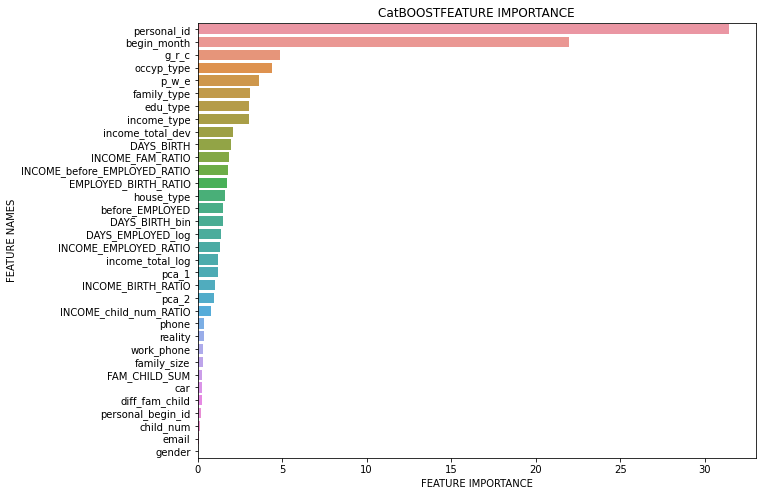

In [25]:
#plot the xgboost result
plot_feature_importance(cat_models[0].get_feature_importance(), train_x.columns,'CatBOOST')

# 최종 모델 fit 전체로 학습

In [31]:
cat = CatBoostClassifier(n_estimators=460, max_depth=8, random_seed=2, learning_rate =0.039, bootstrap_type ='Bernoulli')
cat.fit(train_x, train_y, cat_features=cat_features, verbose=50)
test_predictions = cat.predict_proba(test)

0:	learn: 1.0758299	total: 186ms	remaining: 1m 25s
50:	learn: 0.7382311	total: 6.39s	remaining: 51.3s
100:	learn: 0.7130258	total: 13.4s	remaining: 47.5s
150:	learn: 0.7042771	total: 21.6s	remaining: 44.2s
200:	learn: 0.6978541	total: 29.7s	remaining: 38.3s
250:	learn: 0.6919153	total: 37s	remaining: 30.8s
300:	learn: 0.6838094	total: 45.3s	remaining: 23.9s
350:	learn: 0.6768225	total: 53.4s	remaining: 16.6s
400:	learn: 0.6707074	total: 1m 1s	remaining: 9.07s
450:	learn: 0.6646937	total: 1m 9s	remaining: 1.39s
459:	learn: 0.6635025	total: 1m 11s	remaining: 0us


# 결과 확인 및 제출 파일 생성

In [35]:
my_submission = test_predictions 
#my_submission

In [36]:
# my_submission_mean = (my_submission1 + my_submission2 + my_submission3)/3
# my_submission_mean

In [37]:
submission=pd.read_csv('./open/sample_submission.csv')
submission.loc[:,1:]=my_submission
submission

,index,0,1,2
0,26457,0.109900,0.173373,0.716728
1,26458,0.370672,0.217024,0.412304
2,26459,0.045895,0.067714,0.886391
3,26460,0.057686,0.070529,0.871786
4,26461,0.076061,0.200320,0.723620
...,...,...,...,...
9995,36452,0.068485,0.225068,0.706447
9996,36453,0.132185,0.429021,0.438794
9997,36454,0.056790,0.092589,0.850621
9998,36455,0.134452,0.339977,0.525571


In [38]:
submission.to_csv('./submit/10fold_cat_0.66474_fit_460_0.6635025.csv', index=False) 

In [39]:
submission.head(20)

,index,0,1,2
0,26457,0.109900,0.173373,0.716728
1,26458,0.370672,0.217024,0.412304
2,26459,0.045895,0.067714,0.886391
3,26460,0.057686,0.070529,0.871786
4,26461,0.076061,0.200320,0.723620
5,26462,0.055830,0.129516,0.814654
6,26463,0.611284,0.365833,0.022883
7,26464,0.049127,0.083763,0.867111
8,26465,0.066745,0.099655,0.833600
9,26466,0.055744,0.293873,0.650383
